In [1]:
"""
QuantifyTubeEnrichment-timeseries

Liv Jensen, Hurley Lab
University of California, Berkeley


Copyright (c) 2022 Liv Jensen, University of California, Berkeley

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE. """


import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from skimage.filters import threshold_otsu
import scipy.ndimage.filters as filters
%matplotlib inline

In [2]:
# imports image file; uses multiple channels, including lipid channel
# fname = '/Volumes/LIVDATA/20200731/1002/1002tuberoi.tif'
def quantify(fnames, label, numchannels=4, membrane=2, c1=0, c2=1, size=5, save=True):
    """
    Quantifies fluorescence signal in all channels for 2 ROIs: GUV surface and tube surface
    
    :param fnames: an array of length 2 with pathnames for the GUV and tube ROI .tif files
    :param label: a unique identifier string applied to a saved output file
    :param numchannels: total number of channels, default is 4
    :param membrane: what channel is the membrane fluor? indexed from zero.
    :param c1: first channel to quantify
    :param c2: 2nd channel to quantify
    :param size: size of 2-D blur used to create membrane mask, default is 5 or 7
    :param save: boolean if true, output is saved to a .csv file
    :return: array of shape (numframes,numchannels,2), where last dimension is GUV (0) or tube (1) ROI.
    """
    for k in range(len(fnames)):
        im = io.imread(fnames[k])
        lipid=im[:,:,:,membrane]
        plt.figure()
        if k == 0:
            signal = np.zeros((len(lipid),numchannels,2))
        for j in range(numchannels):
            dat = im[:,:,:,j]
            for i in range(len(lipid)):
                im_max = filters.maximum_filter(lipid[i], size)
                im_min = filters.minimum_filter(lipid[i], size)
                im_diff = im_max - im_min
                thresh = threshold_otsu(im_diff)
                bool_diff = (im_diff < thresh)
                masked_dat = dat[i].copy()
                masked_dat[bool_diff] = False
                plt.imshow(bool_diff)
                datav = np.average(masked_dat[masked_dat != 0])
                backgroundout = np.average(dat[i][masked_dat == 0])
                signal[i,j,k] = datav - backgroundout
    
    head = "c1, c2, membrane, brightfield"
    if save==True:
        for k in range(len(fnames)):
            np.savetxt(fnames[k]+label+".csv", signal[:,:,k], delimiter=',',header=head, fmt='%f')
    return signal


def enrichment(signal, numchannels=2, membrane=2, c1=0, c2=1, ktub=1,verbose=False):
    output = np.zeros((len(signal[:,0,0]), numchannels-1))
    for i in range(len(signal[:,0,0])):
        output[i,0] = signal[i,membrane,1]/signal[i,membrane,0]*ktub #radius
        output[i,1] = (signal[i,c1,1]/signal[i,membrane,1])/(signal[i,c1,0]/signal[i,membrane,0]) #c1 tube enrichment
        output[i,2] = (signal[i,c2,1]/signal[i,membrane,1])/(signal[i,c2,0]/signal[i,membrane,0]) #c2 tube enrichment
    if verbose == True:
        print(output)
    return output


def save_to_csv(data, outpath, label):
    """
    data: output from enrichment function
    """
    head = "tub/GUV ratio, c1 tube enrichment, c2 tube enrichment"
    np.savetxt(outpath+label+"data.csv", data, delimiter=',',header=head, fmt='%f')


(80, 38, 51, 4)
(80, 38, 51, 4)


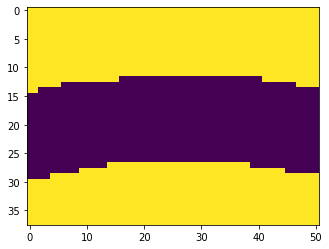

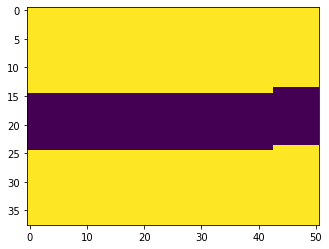

In [53]:
# input pathname for GUV and tube ROIs, and quantify signal. toggle save param to save .csv output
data = ['GUV_ROIpath','tube_ROIpath']
label = 'uniqueID'
signal = quantify(data, label, save=False, numchannels=4, membrane=2, size=7)
# print(signal)


# calculate protein enrichment on the tube
enr = enrichment(signal)